In [2]:
import numpy as np
import ot
import scipy.stats as sps
import scipy.linalg as spl
from scipy.optimize import linprog
import matplotlib.pyplot as plt

#################
### author : Julie Delon
#################

###############################
#### display GMM
###############################


def display_gmm(gmm,n=50,ax=0,bx=1,ay=0,by=1,cmap='viridis',axis=None):
    
    if axis is None:
        axis = plt.gca()
        
    [K,pi,mu,S] = gmm
    
    x = np.linspace(ax, bx,num=n)
    y = np.linspace(ay, by,num=n)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = densite_theorique2d(mu,S,pi,XX)
    Z = Z.reshape(X.shape)
    plt.axis('equal')
    return axis.contour(X, Y, Z,8,cmap=cmap)    





###############################
#### compute GMM densities
###############################

def densite_theorique(mu,var,alpha,x):
    # compute the 1D GMM density with parameters (mu,var) and weights alpha  at x 
    K=mu.shape[0]
    y=0
    #y=np.zeros(len(x))
    for j in range(K):
        y+=alpha[j]*sps.norm.pdf(x,loc=mu[j,:],scale=np.sqrt(var[j,:,:]))
    return y.reshape(x.shape)

def densite_theorique2d(mu,Sigma,alpha,x):
    # compute the 2D GMM density with parameters (mu, Sigma) and weights alpha at x
    K = mu.shape[0]
    alpha = alpha.reshape(1,K)
    y=0
    for j in range(K):
        y+=alpha[0,j]*sps.multivariate_normal.pdf(x,mean=mu[j,:],cov=Sigma[j,:,:])
    return y

###############################
### Optimal Transport between Gaussians (quadratic Wasserstein)
###############################

def GaussianW2(m0,m1,Sigma0,Sigma1):
    # compute the quadratic Wasserstein distance between two Gaussians with means m0 and m1 and covariances Sigma0 and Sigma1
    Sigma00  = spl.sqrtm(Sigma0)
    Sigma010 = spl.sqrtm(Sigma00@Sigma1@Sigma00)
    d        = np.linalg.norm(m0-m1)**2+np.trace(Sigma0+Sigma1-2*Sigma010)
    return d

def GaussianMap(m0,m1,Sigma0,Sigma1,x):
    # Compute the OT map (evaluated at x) between two Gaussians with means m0 and m1 and covariances Sigma0 and Sigma1 
    # m0 and m1 must be 2D arrays of size 1xd
    # Sigma0 and Sigma1 must be 2D arrays of size dxd
    # x can be a matrix of size n x d,
    # each column of x is a vector to which the function is applied
    d = Sigma0.shape[0]
    m0 = m0.reshape(1,d)
    m1 = m1.reshape(1,d)
    Sigma0 = Sigma0.reshape(d,d)
    Sigma1 = Sigma1.reshape(d,d)
    Sigma  = np.linalg.inv(Sigma0)@spl.sqrtm(Sigma0@Sigma1)
    Tx        = m1+(x-m0)@Sigma
    return Tx

def GaussianBarycenterW2(mu,Sigma,alpha,N):
    # Compute the W2 barycenter between several Gaussians
    # mu has size Kxd, with K the number of Gaussians and d the space dimension
    # Sigma has size Kxdxd
    K        = mu.shape[0]  # number of Gaussians
    d        = mu.shape[1]  # size of the space
    Sigman   = np.eye(d,d)
    mun      = np.zeros((1,d))
    cost = 0
    
    for n in range(N):
        Sigmandemi       = spl.sqrtm(Sigman)
        T = np.zeros((d,d))
        for j in range(K):
            T+= alpha[j]*spl.sqrtm(Sigmandemi@Sigma[j,:,:]@Sigmandemi)
        Sigman  = T
    
    for j in range(K):
        mun+= alpha[j]*mu[j,:]
    
    for j in range(K):
        cost+= alpha[j]*GaussianW2(mu[j,:],mun,Sigma[j,:,:],Sigman)

    return mun,Sigman,cost       # return the Gaussian Barycenter (mun,Sigman) and the total cost


###############################
###### GW2 between GMM
###############################


def GW2(pi0,pi1,mu0,mu1,S0,S1):
    # return the GW2 discrete map and the GW2 distance between two GMM
    K0 = mu0.shape[0]
    K1 = mu1.shape[0]
    d  = mu0.shape[1]
    S0 = S0.reshape(K0,d,d)
    S1 = S1.reshape(K1,d,d)
    M  = np.zeros((K0,K1))
    # First we compute the distance matrix between all Gaussians pairwise
    for k in range(K0):
        for l in range(K1):
            M[k,l]  = GaussianW2(mu0[k,:],mu1[l,:],S0[k,:,:],S1[l,:,:])
    # Then we compute the OT distance or OT map thanks to the OT library
    wstar     = ot.emd(pi0,pi1,M)         # discrete transport plan
    distGW2   = np.sum(wstar*M)
    return wstar,distGW2

def GW2cost(mu0,mu1,S0,S1):       # return the distance matrix M of size K0 x K1
    K0 = mu0.shape[0]
    K1 = mu1.shape[0]
    M = np.zeros((K0,K1))
    # we compute the distance matrix between all Gaussians pairwise
    for k in range(K0):
        for l in range(K1):
            M[k,l]  = GaussianW2(mu0[k,:],mu1[l,:],S0[k,:,:],S1[l,:,:])
    return M

def GW2_map(pi0,pi1,mu0,mu1,S0,S1,wstar,x):      
    # return the GW2 maps between two GMM on the 1D grid x  
    n,K0,K1    = x.shape[0],mu0.shape[0],mu1.shape[0]
    T          = np.zeros((K0,K1,n))     # each Tkl = T[k,l,:] is of dimension n and correspond to the W2-map between component k of mu0 and component l of mu1
    tmpmean    = np.zeros(n)
    weightmean = np.zeros(n)
    Tmean      = np.zeros((n,n))     # averaged map on a grid 
    Tmap       = np.zeros((n,n))     # multivalued map on a grid
    
    for k in range(K0):
        for l in range(K1):
            if wstar[k,l]!=0:
                T[k,l,:] = GaussianMap(mu0[k,:],mu1[l,:],S0[k,],S1[l],x).reshape(n,)
                for i in range(n):
                    Ti             = int(max(min(T[k,l,i],1),0)*99)
                    Tmap[i,Ti]    += wstar[k,l]*sps.norm.pdf(x[i],loc=mu0[k],scale=np.sqrt(S0[k]))
                    tmpmean[i]    += wstar[k,l]*sps.norm.pdf(x[i],loc=mu0[k],scale=np.sqrt(S0[k]))/densite_theorique(mu0,S0,pi0,x[i])*T[k,l,i]
                    weightmean[i] += wstar[k,l]*sps.norm.pdf(x[i],loc=mu0[k],scale=np.sqrt(S0[k]))

    tmpmean = np.uint(np.maximum(np.minimum(tmpmean,1),0)*99)
    for i in range(n):
        Tmean[i,tmpmean[i]] = weightmean[i]
    
    return Tmap,Tmean


#####################################################
##### Multimarginal problem
#####################################################


def create_cost_matrix_from_gmm(gmm,alpha,N=10):
    """
    create the cost matrix for the multimarginal problem between all GMM
    create the barycenters (mun,Sn) betweenn all Gaussian components 
    """
    
    nMarginal       = len(alpha)               # number of marginals
    d               = gmm[0][2].shape[1]       # space dimension
    tup = ();
    for k in range(nMarginal):
        K  = gmm[k][0]
        tup+=(K,)        
    C               = np.zeros(tup)
    mun             = np.zeros(tup+(d,))
    Sn             = np.zeros(tup+(d,d))
        
    it = np.nditer(C,["multi_index"])
    while not it.finished:
        tup = it.multi_index        
        mu = np.zeros((nMarginal,d))
        Sigma = np.zeros((nMarginal,d,d))
        
        for k in range(nMarginal):
            mu[k,:]      = gmm[k][2][tup[k]]
            Sigma[k,:,:] = gmm[k][3][tup[k]]
            
        mu    = np.array(mu)    
        Sigma = np.array(Sigma)    
        [mun[tup],Sn[tup],cost] = GaussianBarycenterW2(mu,Sigma,alpha,N)
        
        C[tup] = cost
        
        it.iternext()
    
    return C,mun,Sn  

def solveMMOT(pi, costMatrix, epsilon = 1e-10):
    """ Author : Alexandre Saint-Dizier
    
    Solveur of the MultiMargnal OT problem, using linprog

    Input :
     - pi : list(array) -> weights of the different distributions
     - C : array(d1,...dp) -> cost matrix
     - epsilon : smallest value considered to be positive

    Output :
     - gamma : list of combinaison with positive weight
     - gammaWeights : corresponding weights
    """

    nMarginal = len(pi);
    nPoints = costMatrix.shape;

    nConstraints = 0; nParameters = 1;
    for ni in nPoints:
        nConstraints += ni; nParameters *= ni

    index = 0;
    A = np.zeros((nConstraints, nParameters)); b = np.zeros(nConstraints)
    for i in range(nMarginal):
        ni = nPoints[i];
        b[index:index+ni] = pi[i];
        for k in range(ni):
            Ap = np.zeros(costMatrix.shape);
            tup = ();
            for j in range(nMarginal):
                if j==i:
                    tup+= (k,)
                else:
                    tup+=(slice(0,nPoints[j]),)
            Ap[tup] = 1;
            A[index+k,:]=Ap.flatten();
        index += ni
    A = A.tolist(); b = b.tolist();
    C = costMatrix.flatten().tolist()

    res = linprog(C, A_eq=A, b_eq =b) #Solve inf <C,X> with constraints AX=b
    gammaWeights = res.x;
    gammaWeights = gammaWeights.reshape(costMatrix.shape)
   
    return gammaWeights







####################################################
#### for color transfer or color barycenters   #####
#### guided_filter is used for post-processing #####
####################################################


def average_filter(u,r):
    # uniform filter with a square (2*r+1)x(2*r+1) window
    # u is a 2d image
    # r is the radius for the filter
    
    (nrow, ncol)                                      = u.shape
    big_uint                                          = np.zeros((nrow+2*r+1,ncol+2*r+1))
    big_uint[r+1:nrow+r+1,r+1:ncol+r+1]               = u
    big_uint                                          = np.cumsum(np.cumsum(big_uint,0),1)       # integral image
    
    out = big_uint[2*r+1:nrow+2*r+1,2*r+1:ncol+2*r+1] + big_uint[0:nrow,0:ncol] - big_uint[0:nrow,2*r+1:ncol+2*r+1] - big_uint[2*r+1:nrow+2*r+1,0:ncol]
    out = out/(2*r+1)**2
    
    return out

def guided_filter(u,guide,r,eps):
    C           = average_filter(np.ones(u.shape), r)   # to avoid image edges pb
    mean_u      = average_filter(u, r)/C
    mean_guide  = average_filter(guide, r)/C
    corr_guide  = average_filter(guide*guide, r)/C
    corr_uguide = average_filter(u*guide, r)/C
    var_guide   = corr_guide - mean_guide * mean_guide
    cov_uguide  = corr_uguide - mean_u * mean_guide
    
    alph = cov_uguide / (var_guide + eps)
    beta = mean_u - alph * mean_guide
    
    mean_alph = average_filter(alph, r)/C
    mean_beta = average_filter(beta, r)/C
    
    q = mean_alph * guide + mean_beta
    return q

In [3]:
import PyAPD
import torch

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


In [4]:
import numpy as np
import scipy.linalg as spl
import scipy.stats as sps
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.optimize import linprog
import ot                 # Optimal Transport library https://github.com/rflamary/POT

import sklearn.mixture 

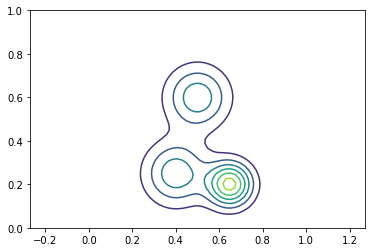

In [7]:
d  = 2 #space dimension

# 2D Gaussian mixtures
K0,K1 = 2,3
pi0 = np.array([[0.5,0.5]])
mu0 = np.array([[0.3,0.3],[0.7,0.4]])
S0 = np.array([[[ .01, 0],[0,  .01]],[[ 0.01, 0],[0,  0.01]]])

pi1 = np.array([[0.35,0.35,0.3]])
mu1 = np.array([[0.5,0.6],[0.4,0.25],[0.65,0.2]])
S1 = np.array([[[ .01, 0],[0,  .01]],[[ 0.01, 0],[0,  0.01]], [[ 0.005, 0],[0,  0.005]]])

# display
n=50    
x = np.linspace(0, 1,num=n)
y = np.linspace(0, 1,num=n)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T

Z = densite_theorique2d(mu0,S0,pi0,XX)
Z = Z.reshape(X.shape)
Z2 = densite_theorique2d(mu1,S1,pi1,XX,)
Z2 = Z2.reshape(X.shape)
#CS = plt.contour(X, Y, Z,8,cmap='plasma')
CS = plt.contour(X, Y, Z2,8,cmap='viridis')
plt.axis('equal');   

In [8]:
wstar,dist = GW2(np.ravel(pi0),np.ravel(pi1),mu0.reshape(K0,d),mu1.reshape(K1,d),S0.reshape(K0,d,d),S1.reshape(K1,d,d))
wstar

array([[0.15, 0.35, 0.  ],
       [0.2 , 0.  , 0.3 ]])

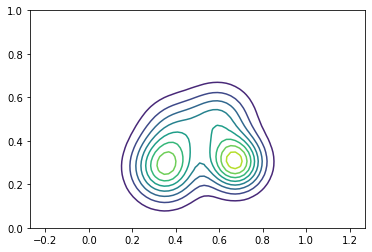

In [15]:
def barygmmot2d(t):
# Barycenters for GW2 in 2d
    pit = wstar.reshape(K0*K1,1).T
    mut = np.zeros((K0*K1,2))
    St  = np.zeros((K0*K1,2,2))
    for k in range(K0):
        for l in range(K1):
            mut[k*K1+l,:]  = (1-t)*mu0[k,:]+t*mu1[l,:]
            Sigma1demi = spl.sqrtm(S1[l,:,:])
            C   = Sigma1demi@spl.inv(spl.sqrtm(Sigma1demi@S0[k,:,:]@Sigma1demi))@Sigma1demi
            St[k*K1+l,:,:] = ((1-t)*np.eye(2)+t*C)@S0[k,:,:]@((1-t)*np.eye(2)+t*C)
    
    # contour plot
    Z = densite_theorique2d(mut,St,pit,XX)
    Z = Z.reshape(X.shape)
    CS = plt.contour(X, Y, Z,8)
    plt.axis('equal')

    
barygmmot2d(0.5)

In [16]:
from ipywidgets import interact, interactive, fixed, interact_manual

In [17]:
interact(barygmmot2d,t=(0.0,1.0,0.05))

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.05), Output()), _dom_classes=('w…

<function __main__.barygmmot2d(t)>

(0.0, 1.0, 0.0, 1.0)

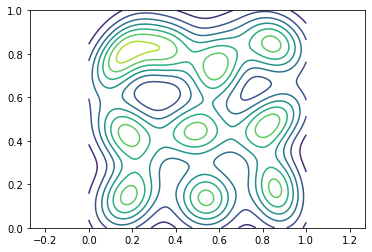

In [434]:
t = 0.1
# Barycenters for GW2 in 2d
pit = wstar.reshape(K0*K1,1).T
mut = np.zeros((K0*K1,2))
St  = np.zeros((K0*K1,2,2))
for k in range(K0):
    for l in range(K1):
        mut[k*K1+l,:]  = (1-t)*mu0[k,:]+t*mu1[l,:]
        Sigma1demi = spl.sqrtm(S1[l,:,:])
        C   = Sigma1demi@spl.inv(spl.sqrtm(Sigma1demi@S0[k,:,:]@Sigma1demi))@Sigma1demi
        St[k*K1+l,:,:] = ((1-t)*np.eye(2)+t*C)@S0[k,:,:]@((1-t)*np.eye(2)+t*C)

# contour plot
Z = densite_theorique2d(mut,St,pit,XX)
Z = Z.reshape(X.shape)
CS = plt.contour(X, Y, Z,8)
plt.axis('equal')

In [436]:
pit

array([[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0.1, 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. ]])

In [18]:
apd1 = PyAPD.apd_system(pixel_size_prefactor = 10, seed = 1)
apd2 = PyAPD.apd_system(pixel_size_prefactor = 10, seed = 2)

In [19]:
apd1.check_optimality()
apd1.Lloyds_algorithm(K = 20, verbosity_level=0)

Precision loss detected!
Percentage error =  54.901611328125
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.7357895374298096
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.5796626210212708
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.6837472319602966
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.9751841425895691
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.6108880043029785
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.6525218486785889
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.8190572261810303
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.6277188658714294
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.57

(<Figure size 756x756 with 1 Axes>, <Axes: >)

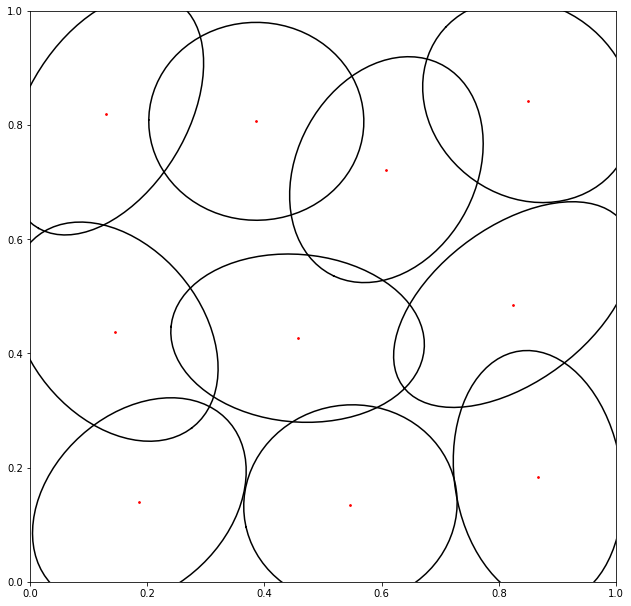

In [20]:
apd1.plot_ellipses()

Precision loss detected!
Percentage error =  68.41172790527344
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.5340427160263062
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.9711980819702148
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.5172118544578552
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.5444511771202087
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.7422119379043579
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.40271878242492676
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.6004795432090759
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.4715919494628906
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0

(<Figure size 756x756 with 1 Axes>, <Axes: >)

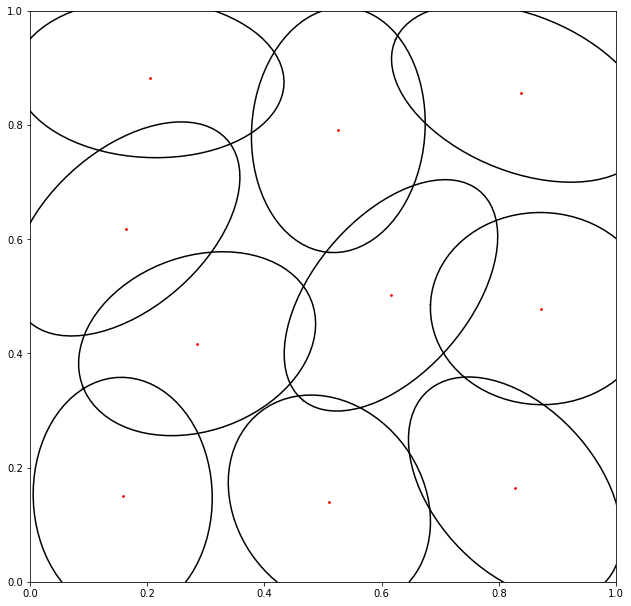

In [21]:
apd2.check_optimality()
apd2.Lloyds_algorithm(K = 20,verbosity_level=0)
apd2.plot_ellipses()

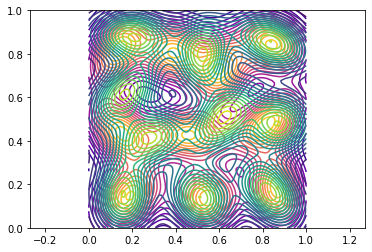

In [26]:
assert apd1.D == apd2.D
d  = apd1.D #space dimension

# 2D Gaussian mixtures
K0,K1 = apd1.N, apd2.N
#pi0 = np.array([[0.5,0.5]])
pi0 = np.array((1/K0,)*K0)
#mu0 = np.array([[0.3,0.3],[0.7,0.4]])
mu0 = np.array(apd1.X)
#S0 = np.array([[[ .01, 0],[0,  .01]],[[ 0.01, 0],[0,  0.01]]])
#scaling = ((apd1.target_masses/torch.pi)**(2)).reshape(K0,1,1)

res_param = 0.01

S0 = np.array(res_param*torch.linalg.inv(apd1.As))

#pi1 = np.array([[0.35,0.35,0.3]])
pi1 = np.array((1/K1,)*K1)

#mu1 = np.array([[0.5,0.6],[0.4,0.25],[0.65,0.2]])
mu1 = np.array(apd2.X)

#S1 = np.array([[[ .01, 0],[0,  .01]],[[ 0.01, 0],[0,  0.01]], [[ 0.005, 0],[0,  0.005]]])
S1 = np.array(res_param*torch.linalg.inv(apd2.As))

# display
n=100
x = np.linspace(0, 1,num=n)
y = np.linspace(0, 1,num=n)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T

Z = densite_theorique2d(mu0,S0,pi0,XX)
Z = Z.reshape(X.shape)
Z2 = densite_theorique2d(mu1,S1,pi1,XX,)
Z2 = Z2.reshape(X.shape)
CS = plt.contour(X, Y, Z,20,cmap='plasma')
CS = plt.contour(X, Y, Z2,20,cmap='viridis')
plt.axis('equal');   

In [27]:
wstar,dist = GW2(np.ravel(pi0),np.ravel(pi1),mu0.reshape(K0,d),mu1.reshape(K1,d),S0.reshape(K0,d,d),S1.reshape(K1,d,d))
wstar

array([[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1],
       [0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. ]])

(0.0, 1.0, 0.0, 1.0)

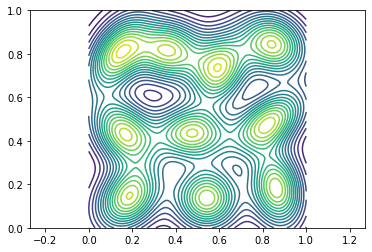

In [28]:
t = 0.1
# Barycenters for GW2 in 2d
pit = wstar.reshape(K0*K1,1).T
II = pit > 1e-4

mut = np.zeros((K0*K1,2))
St  = np.zeros((K0*K1,2,2))
for k in range(K0):
    for l in range(K1):
        mut[k*K1+l,:]  = (1-t)*mu0[k,:]+t*mu1[l,:]
        Sigma1demi = spl.sqrtm(S1[l,:,:])
        C   = Sigma1demi@spl.inv(spl.sqrtm(Sigma1demi@S0[k,:,:]@Sigma1demi))@Sigma1demi
        St[k*K1+l,:,:] = ((1-t)*np.eye(2)+t*C)@S0[k,:,:]@((1-t)*np.eye(2)+t*C)

# contour plot
Z = densite_theorique2d(mut[II[0]],St[II[0]],pit[II],XX)
#Z = densite_theorique2d(mut,St,pit,XX)
Z = Z.reshape(X.shape)
CS = plt.contour(X, Y, Z,20)
plt.axis('equal')

In [29]:
def blending(t):
    pit = wstar.reshape(K0*K1,1).T
    II = pit > 1e-4
    
    mut = np.zeros((K0*K1,2))
    St  = np.zeros((K0*K1,2,2))
    for k in range(K0):
        for l in range(K1):
            mut[k*K1+l,:]  = (1-t)*mu0[k,:]+t*mu1[l,:]
            Sigma1demi = spl.sqrtm(S1[l,:,:])
            C   = Sigma1demi@spl.inv(spl.sqrtm(Sigma1demi@S0[k,:,:]@Sigma1demi))@Sigma1demi
            St[k*K1+l,:,:] = ((1-t)*np.eye(2)+t*C)@S0[k,:,:]@((1-t)*np.eye(2)+t*C)
    
    # contour plot
    Z = densite_theorique2d(mut[II[0]],St[II[0]],pit[II],XX)
    #Z = densite_theorique2d(mut,St,pit,XX)
    Z = Z.reshape(X.shape)
    #CS = plt.contour(X, Y, Z,20)
    #plt.axis('equal')
    X_t = torch.tensor(mut[II[0]])
    A_t = torch.tensor((1/res_param)*St[II[0]])
    A_t_inv = torch.linalg.inv(A_t).contiguous()
    apd_t = PyAPD.apd_system(N=apd1.N,X = X_t, As = A_t_inv,pixel_size_prefactor = 10)
    apd_t.check_optimality()
    apd_t.find_optimal_W()
    apd_t.plot_apd()


In [30]:
interact(blending,t=(0.0,1.0,0.05))

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.05), Output()), _dom_classes=('w…

<function __main__.blending(t)>

Precision loss detected!
Percentage error =  17.645553588867188
Solver tolerance is with respect to each grain separately.
Smallest tol:  tensor(0.0010)
Optimality condition successfully overwritten.
Optimization terminated successfully.
         Current function value: -0.018290
         Iterations: 6
         Function evaluations: 8
It took 0.12048912048339844 seconds to find optimal W.


(<Figure size 756x756 with 1 Axes>, <Axes: >)

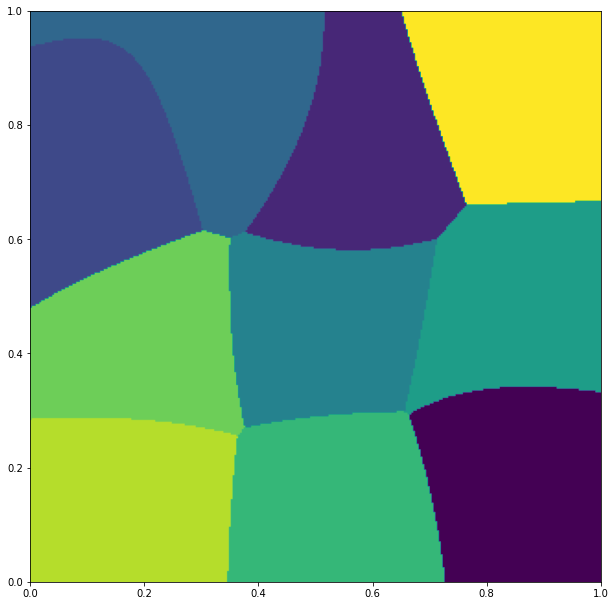

(<Figure size 756x756 with 1 Axes>, <Axes: >)

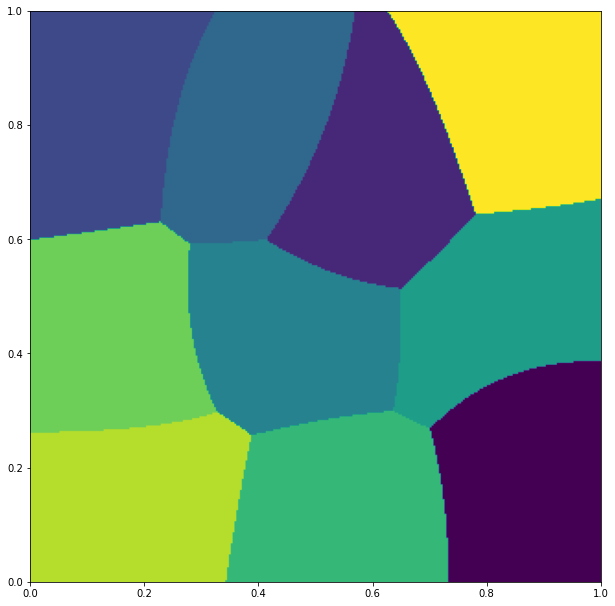

In [499]:
apd1.plot_apd()

The APD is optimal!
Percentage error =  0.8398741483688354
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.3987327218055725
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.48598647117614746
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.6837472319602966
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.8775219321250916
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.7566064596176147
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.7942542433738708
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.5588456988334656
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.49639493227005005
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.35

(<Figure size 756x756 with 1 Axes>, <Axes: >)

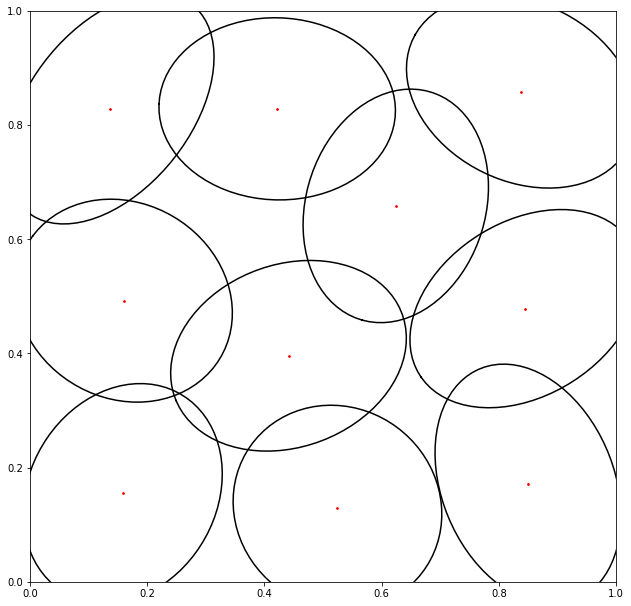

In [500]:
apd_t.check_optimality()
apd_t.Lloyds_algorithm(K=20, verbosity_level=0)
apd_t.plot_ellipses()

(<Figure size 756x756 with 1 Axes>, <Axes: >)

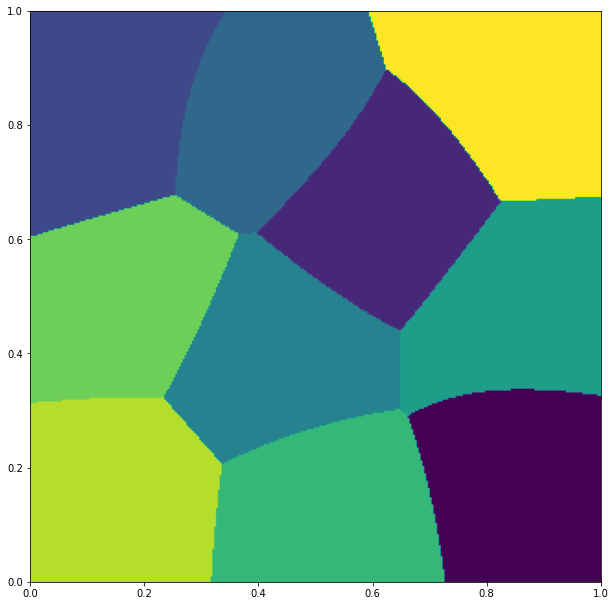

In [501]:
apd_t.plot_apd()

(<Figure size 756x756 with 1 Axes>, <Axes: >)

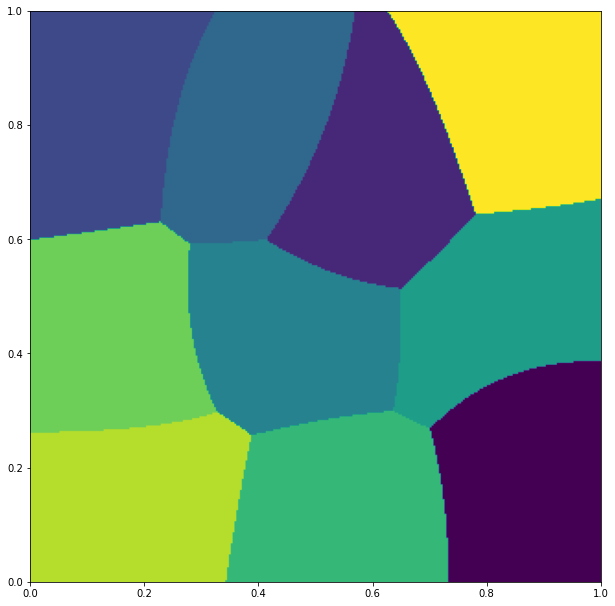

In [502]:
apd1.plot_apd()

In [31]:
apd3d = PyAPD.apd_system(D=3,N=20,pixel_size_prefactor=8)

In [32]:
apd3d.assemble_pixels()

In [33]:
apd3d.Y.shape

torch.Size([884736, 3])

In [34]:
apd3d.Lloyds_algorithm(K=5)

Lloyds iteration: 0
Optimality condition successfully overwritten.
[KeOps] Generating code for formula ArgMin_Reduction((Var(0,3,1)-Var(1,3,0))|MatVecMult(Var(2,9,0),Var(0,3,1)-Var(1,3,0))-Var(3,1,0),1) ... OK
[pyKeOps] Compiling pykeops cpp 203e0ca86a module ... OK
The APD is optimal!
Percentage error =  0.7630065083503723
Lloyds iteration: 1
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.6636753678321838
Lloyds iteration: 2
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.8375793695449829
Lloyds iteration: 3
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.5778893828392029
Lloyds iteration: 4
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.9278059005737305


In [35]:
apd3d.assemble_apd()

tensor([18, 18, 18,  ...,  4,  4,  4])

In [36]:
apd3d.domain[0:2]

tensor([[0., 1.],
        [0., 1.]])

In [37]:
img = apd3d.assemble_apd().reshape(apd3d.pixel_params).transpose(0,1).cpu()
img.shape

torch.Size([96, 96, 96])

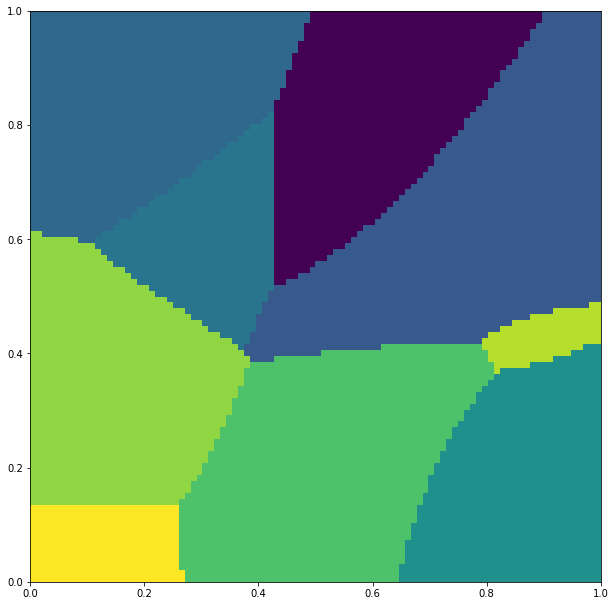

In [39]:
fig, (ax1) = plt.subplots(1,1)
fig.set_size_inches(10.5, 10.5, forward=True)
ax1.imshow(img[:,:,45], origin='lower', extent = torch.flatten( apd3d.domain[0:2] ).tolist())

In [558]:
img[:,:,2]

tensor([[ 5,  5,  5,  ...,  4,  4,  4],
        [ 5,  5,  5,  ...,  4,  4,  4],
        [ 5,  5,  5,  ...,  4,  4,  4],
        ...,
        [11, 11, 11,  ...,  7,  7,  7],
        [11, 11, 11,  ...,  7,  7,  7],
        [11, 11, 11,  ...,  7,  7,  7]])